## Workflow to GPU

A quick recap of the concept explored with PyTorch workflows ported to the GPU.

In [452]:
# Import libraries and packages
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Check our PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Set up GPU access, else default to CPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"PyTorch using: {device}")

# Create some dummy data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.02

# Create features and labels tensors (our X and y)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

# Create a training-testing split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# Create  plotting function to check our model
def plotPredictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
    plt.figure(figsize=(5,3))
    
    plt.scatter(train_data,train_labels, c="b", s=4, label="Training Data")
    
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    plt.legend(prop={"size": 12})

# Linear regression model in pytorch that uses Linear Layer
class LinearRegressionV2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # initialize model parameters
        self.linear_layer = torch.nn.Linear(in_features=1, out_features=1)
        
    # defines the forward computation needed to be done
    # linear regression in this case
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
# A random seed
torch.manual_seed("1234")

# Create an instance of our model
model_1 = LinearRegressionV2()

# Create Mean Absolute Error Loss Function
loss_function = torch.nn.L1Loss()

# Create Optimizer (Stochastic Gradient Descent), Learning Rate Hyperparameter
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

# Send data to target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Send model to target device
model_1.to(device)

# Set number of times to pass data through network
EPOCHS = 1000

# Training Loop
for epoch in range(EPOCHS):
    # enable training mode and track gradients on valid parameters
    model_1.train()  
    
    # forward propagation
    y_predictions = model_1(X_train)
    
    # calculate loss
    loss = loss_function(y_predictions, y_train)
    
    # zero out the optimizer gradients
    optimizer.zero_grad()
    
    # back propagation, compute gradient for every parameter
    loss.backward()
    
    # gradient descent optimizer
    optimizer.step()
    
    # Testing Loop
    # turn off gradient tracking
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_pred = model_1(X_test)
        # loss pass
        test_loss = loss_function(test_pred, y_test)
    
    # Check learning rate, epoch count performance
    if epoch % 200 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Test: {loss} | Test Loss: {test_loss}")

PyTorch version: 1.12.1+cu116
PyTorch using: cuda
Epoch: 0 | Test: 1.1365989446640015 | Test Loss: 1.9441488981246948
Epoch: 200 | Test: 0.20679521560668945 | Test Loss: 0.5034179091453552
Epoch: 400 | Test: 0.13770270347595215 | Test Loss: 0.3214869201183319
Epoch: 600 | Test: 0.06901755183935165 | Test Loss: 0.16084706783294678
Epoch: 800 | Test: 0.003528656903654337 | Test Loss: 0.006962096784263849


In [453]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6940]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2988], device='cuda:0'))])

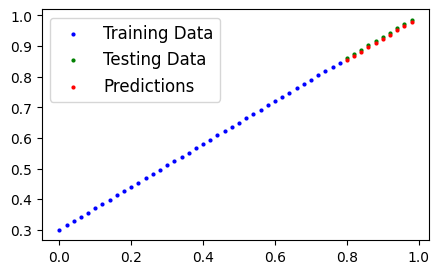

In [455]:
# Evaluate the model on a batch of test data
model_1.eval()
with torch.inference_mode():
    y_predictions = model_1(X_test)

# Use plot function, remember to change GPU tensor to CPU
plotPredictions(predictions=y_predictions.cpu())

In [459]:
# Save Model
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)
model_name = "01_pytorch_recap_model_1.pth"
model_save_path = model_path / model_name
torch.save(obj=model_1.state_dict(), f=model_save_path)

# Create a new intance of our LinearRegressionV2 class
loaded_model_1 = LinearRegressionV2()

# Load Model
loaded_model_1.load_state_dict(torch.load(f=model_save_path))

# Check that our model is loaded correctly into our new instance
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6940]])),
             ('linear_layer.bias', tensor([0.2988]))])